In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from sklearn.decomposition import PCA


import gym_env
import utils
from utils import create_mapping, get_transition_matrix, make_plots, record_trajectory, test_agent

## Linear RL Model

In [2]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        self.mapping = create_mapping(self.maze)
        self.T, self.barriers = get_transition_matrix(self.env, self.size, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -0.1)     # our reward at each non-terminal state to be -1
        self.r[self.terminals] = 1           # reward at terminal state is 0
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)      # exp(r) = exp(-c) at terminal state
        self.expr_nt = np.exp(-0.1/_lambda)     # exp(r) = exp(-c) at non-terminal states

        # Params
        self.alpha = alpha
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_states(self):
        """
        Returns all non-blocked states as well as a mapping of each state (i,j) -> to an index (k)
        """
        states = []
        index_mapping = {}
        index = 0
        for i in range(len(self.maze)):
            for j in range(len(self.maze[i])):
                if self.maze[i][j] in ['0', 'S', 'G']:
                    states.append((i, j))
                    index_mapping[(i, j)] = index
                    index += 1

        return states, index_mapping

    def get_DR(self):
        if self.policy == "random":
            DR = np.eye(self.size)
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            DR[:, self.barriers] = 0
            DR[self.barriers, :] = 0
            np.fill_diagonal(DR, 1)

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=1, target_loc=None):
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
    
        elif self.policy == "egreedy":
            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        # New way of doing it
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        print(f"Decision Policy: {self.policy}")
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state, self.policy)
            else:
                action = self.select_action(state, self.policy)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax":
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            # Update state
            if done:
                self.env.reset()
                continue
            state = next_state
            
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

## Learn DR-TD

In [3]:
agent = LinearRL(env_name="tolman-9x9-nb", _lambda=1.0, alpha=0.01, num_steps=400000, policy="random")

In [4]:
agent.maze

array([['1', '1', '1', 'S', '1', '1', '1', '1', '1'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['1', '1', '1', 'G', '1', '1', '1', '1', '1']], dtype='<U21')

In [5]:
states, mapping = agent.get_states()

In [6]:
len(states)

31

In [7]:
# Run learning on non-blocked detour environment
agent.learn()

Decision Policy: random


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52774/442765447.py:194: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


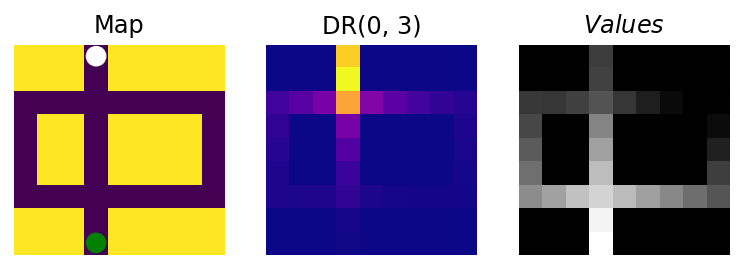

In [8]:
make_plots(agent)

In [9]:
agent.V.reshape((agent.height, agent.width))

array([[ -inf,  -inf,  -inf, -3.08,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf, -3.01,  -inf,  -inf,  -inf,  -inf,  -inf],
       [-3.14, -3.18, -3.04, -2.76, -3.17, -3.53, -3.86, -4.05, -4.03],
       [-2.93,  -inf,  -inf, -1.84,  -inf,  -inf,  -inf,  -inf, -3.84],
       [-2.61,  -inf,  -inf, -1.33,  -inf,  -inf,  -inf,  -inf, -3.49],
       [-2.22,  -inf,  -inf, -0.89,  -inf,  -inf,  -inf,  -inf, -3.06],
       [-1.7 , -1.33, -0.81, -0.4 , -0.91, -1.35, -1.78, -2.25, -2.71],
       [ -inf,  -inf,  -inf,  0.54,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf,  1.  ,  -inf,  -inf,  -inf,  -inf,  -inf]])

In [14]:
##  DONT RUN, ONLY FOR REFERENCE OF VALUES WITH D_INV  ##
D_inv = agent.get_D_inv()
# agent.DR = D_inv
# agent.update_V()
# agent.V.reshape((agent.height, agent.width))

/var/folders/dx/6bb4vg5j0r9cwkqygrg_kqkm0000gn/T/ipykernel_68241/442765447.py:71: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


array([[ -inf,  -inf,  -inf, -3.15,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf, -3.05,  -inf,  -inf,  -inf,  -inf,  -inf],
       [-3.19, -3.23, -3.08, -2.78, -3.21, -3.6 , -3.91, -4.08, -4.06],
       [-2.96,  -inf,  -inf, -1.96,  -inf,  -inf,  -inf,  -inf, -3.85],
       [-2.62,  -inf,  -inf, -1.39,  -inf,  -inf,  -inf,  -inf, -3.52],
       [-2.21,  -inf,  -inf, -0.89,  -inf,  -inf,  -inf,  -inf, -3.11],
       [-1.77, -1.33, -0.88, -0.42, -0.88, -1.33, -1.78, -2.24, -2.68],
       [ -inf,  -inf,  -inf,  0.5 ,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf,  1.  ,  -inf,  -inf,  -inf,  -inf,  -inf]])

In [10]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_not_blocked = test_agent(agent)

Start location: [0 3], Target location: [8 3]
Starting in state: [0 3]
Took action: 0 and arrived in state: [1 3]
Took action: 0 and arrived in state: [2 3]
Took action: 0 and arrived in state: [3 3]
Took action: 0 and arrived in state: [4 3]
Took action: 0 and arrived in state: [5 3]
Took action: 0 and arrived in state: [6 3]
Took action: 0 and arrived in state: [7 3]
Took action: 0 and arrived in state: [8 3]
Took 8 steps


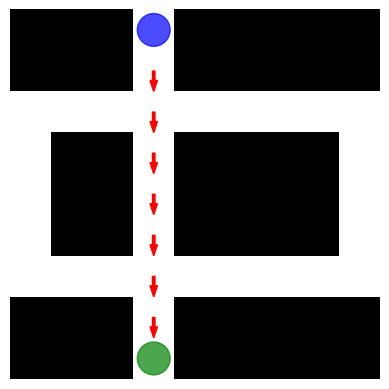

In [11]:
record_trajectory(agent, traj_not_blocked)

## Get state -> state DR and T (excludes blocked squares)

In [12]:
DR = agent.DR
T = agent.T
barriers = agent.barriers

# print(DR.shape)
# print(len(barriers))
# print(barriers, "\n")
# idx = barriers[10]
# print(DR[:,idx])
# print(DR[idx,:])

In [13]:
# Drop rows and columns associated with barriers
# Convert barriers list to a NumPy array
indices = np.array(barriers)

# Create a boolean mask to identify rows and columns to keep
mask = np.ones(DR.shape[0], dtype=bool)
mask[indices] = False

# Use boolean indexing to select rows and columns to keep
DR_new = DR[mask][:, mask]
T_new = T[mask][:,mask]

In [14]:
print(f"Number of blocked squares: {len(barriers)}")
print(f"Old DR shape: {DR.shape}, New DR shape: {DR_new.shape}")
print(f"Old T shape: {T.shape}, New T shape: {T_new.shape}")

Number of blocked squares: 50
Old DR shape: (81, 81), New DR shape: (31, 31)
Old T shape: (81, 81), New T shape: (31, 31)


## Detour

In [15]:
# Get new maze and initialize a new agent
env_blocked = gym.make("tolman-9x9-b")
maze_blocked = env_blocked.unwrapped.maze
new_agent = LinearRL(env_name="tolman-9x9-b", _lambda=1.0, alpha=0.01)

In [16]:
# Find states whose transition has been changed
delta_T = agent.T - new_agent.T

In [17]:
## OLD
# delta_locs = [30, 39, 48]

## NEW
delta_locs = [12, 15, 18]

In [18]:
maze_blocked

array([['1', '1', '1', 'S', '1', '1', '1', '1', '1'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '1', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['1', '1', '1', 'G', '1', '1', '1', '1', '1']], dtype='<U21')

In [19]:
T = T_new
T_new = new_agent.T[mask][:,mask]
DR = DR_new
r = agent.r[mask]

In [20]:
## OLD
# L0 = np.diag(np.exp(-agent.r)) - T_new
# L = np.diag(np.exp(-agent.r)) - new_agent.T

## New
L0 = np.diag(np.exp(-r)) - T
L = np.diag(np.exp(-r)) - T_new

In [21]:
delta = L[delta_locs] - L0[delta_locs]
delta.shape

(3, 31)

In [22]:
## OLD
# D0 = agent.DR
# D0 = agent.get_D_inv()
# D0_j = D0[:,delta_locs]
# D0_j.shape

## NEW
# D0 = DR
D0 = agent.get_D_inv()[mask][:,mask]

D0_j = D0[:,delta_locs]
D0_j.shape

(31, 3)

In [23]:
I = np.eye(len(delta_locs))
I.shape

(3, 3)

In [24]:
inv = np.linalg.inv(I + np.dot(delta, D0_j))
inv.shape

(3, 3)

In [25]:
B = np.dot( np.dot(D0_j, inv), np.dot(delta, D0) )
B.shape

(31, 31)

In [26]:
D = D0 - B
D.shape

(31, 31)

#### We want to recover the DR now

In [27]:
mask.shape

(81,)

In [34]:
mask

array([False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False])

In [28]:
# Recover the original DR matrix with operations reflected
DR_det = np.copy(agent.DR)   # Copy the old DR
DR_det[np.ix_(mask, mask)] = D   # Replace the locations of the mask with the new DR

In [43]:
agent.DR[3]

array([0.        , 0.        , 0.        , 1.98450617, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.20230365, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.22176871, 0.34261103,
       0.52865703, 1.743579  , 0.56809103, 0.35442364, 0.22391752,
       0.14439056, 0.09131076, 0.13906537, 0.        , 0.        ,
       0.52978438, 0.        , 0.        , 0.        , 0.        ,
       0.05838403, 0.09359251, 0.        , 0.        , 0.32653151,
       0.        , 0.        , 0.        , 0.        , 0.03874651,
       0.06839427, 0.        , 0.        , 0.18369439, 0.        ,
       0.        , 0.        , 0.        , 0.02696508, 0.05419669,
       0.04701428, 0.05336449, 0.14399223, 0.0465684 , 0.03098572,
       0.02319223, 0.02030077, 0.02135628, 0.        , 0.        ,
       0.        , 0.03375621, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [48]:
mask

array([False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False])

In [46]:
D[0]

array([ 2.0641362 ,  2.35210477,  0.27356293,  0.4311679 ,  0.67946552,
        2.14136634,  0.67950517,  0.43125553,  0.27371697,  0.17375255,
        0.11033555,  0.17349969,  0.48550744,  0.07012674,  0.10993069,
       -0.02333569,  0.04466852,  0.06948472,  0.00493084,  0.02860595,
        0.04365429,  0.02700618,  0.0160386 ,  0.01688921,  0.00709157,
        0.00723019,  0.00888962,  0.01241891,  0.01856041,  0.0038205 ,
        0.01816327])

In [38]:
DR_det[3]

array([ 0.        ,  0.        ,  0.        ,  2.0641362 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.35210477,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.27356293,  0.4311679 ,
        0.67946552,  2.14136634,  0.67950517,  0.43125553,  0.27371697,
        0.17375255,  0.11033555,  0.17349969,  0.        ,  0.        ,
        0.48550744,  0.        ,  0.        ,  0.        ,  0.        ,
        0.07012674,  0.10993069,  0.        ,  0.        , -0.02333569,
        0.        ,  0.        ,  0.        ,  0.        ,  0.04466852,
        0.06948472,  0.        ,  0.        ,  0.00493084,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02860595,  0.04365429,
        0.02700618,  0.0160386 ,  0.01688921,  0.00709157,  0.00723019,
        0.00888962,  0.01241891,  0.01856041,  0.        ,  0.        ,
        0.        ,  0.0038205 ,  0.        ,  0.        ,  0.  

In [29]:
new_agent.DR = DR_det
new_agent.update_V()
new_agent.V.reshape((agent.height, agent.width))

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52774/442765447.py:71: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52774/442765447.py:71: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


array([[ -inf,  -inf,  -inf, -5.26,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf, -5.16,  -inf,  -inf,  -inf,  -inf,  -inf],
       [-3.44, -3.9 , -4.38, -4.89, -5.11, -5.15, -4.99, -4.68, -4.29],
       [-2.98,  -inf,  -inf, -4.73,  -inf,  -inf,  -inf,  -inf, -3.87],
       [-2.52,  -inf,  -inf,   nan,  -inf,  -inf,  -inf,  -inf, -3.42],
       [-2.07,  -inf,  -inf, -0.3 ,  -inf,  -inf,  -inf,  -inf, -2.97],
       [-1.61, -1.16, -0.7 , -0.25, -0.7 , -1.16, -1.61, -2.07, -2.52],
       [ -inf,  -inf,  -inf,  0.54,  -inf,  -inf,  -inf,  -inf,  -inf],
       [ -inf,  -inf,  -inf,  1.  ,  -inf,  -inf,  -inf,  -inf,  -inf]])

In [30]:
print("Testing new agent with blocked environment")
print(f"Start location: {new_agent.start_loc}, Target location: {new_agent.target_loc}")
traj_blocked = test_agent(new_agent)

Testing new agent with blocked environment
Start location: [0 3], Target location: [8 3]
Starting in state: [0 3]
Took action: 0 and arrived in state: [1 3]
Took action: 0 and arrived in state: [2 3]
Took action: 3 and arrived in state: [2 2]
Took action: 3 and arrived in state: [2 1]
Took action: 3 and arrived in state: [2 0]
Took action: 0 and arrived in state: [3 0]
Took action: 0 and arrived in state: [4 0]
Took action: 0 and arrived in state: [5 0]
Took action: 0 and arrived in state: [6 0]
Took action: 1 and arrived in state: [6 1]
Took action: 1 and arrived in state: [6 2]
Took action: 1 and arrived in state: [6 3]
Took action: 0 and arrived in state: [7 3]
Took action: 0 and arrived in state: [8 3]
Took 14 steps


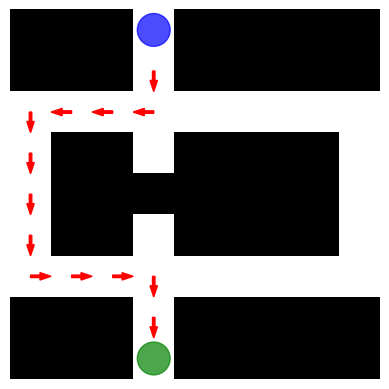

In [31]:
record_trajectory(new_agent, traj_blocked)

In [32]:
print(D.shape)
I = np.eye(31)
D_inv = np.linalg.inv(I-new_agent.gamma*T_new)
print(D_inv.shape)
print(np.max(np.abs(D - D_inv)))

(31, 31)
(31, 31)
0.24774259963065148


In [33]:
np.max(np.abs(new_agent.get_D_inv() - DR_det))

0.24774259963065148

In [98]:
matrix = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])

indices_to_drop = [0, 3]

# Convert barriers list to a NumPy array
indices = np.array(indices_to_drop)

# Create a boolean mask to identify rows and columns to keep
mask = np.ones(matrix.shape[0], dtype=bool)
mask[indices] = False

# Use boolean indexing to select rows and columns to keep
matrix_new = matrix[mask][:, mask]
matrix_new_old = np.copy(matrix_new)
matrix_new += 1

# Recover the original NxN matrix with operations reflected
recovered_matrix = np.copy(matrix)
recovered_matrix[np.ix_(mask, mask)] = matrix_new
print(mask)
print(np.ix_(mask, mask))

print("Original Matrix:")
print(matrix)
print("\nResult Matrix:")
print(matrix_new_old)
print("\nResult Matrix after operations:")
print(matrix_new)
print("\nRecovered NxN Matrix:")
print(recovered_matrix)

[False  True  True False]
(array([[1],
       [2]]), array([[1, 2]]))
Original Matrix:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Result Matrix:
[[ 6  7]
 [10 11]]

Result Matrix after operations:
[[ 7  8]
 [11 12]]

Recovered NxN Matrix:
[[ 1  2  3  4]
 [ 5  7  8  8]
 [ 9 11 12 12]
 [13 14 15 16]]


### Grid Cells

In [67]:
D_old = agent.DR
D_new = new_agent.DR

In [68]:
print(D_old.shape, D_new.shape)

(81, 81) (81, 81)


In [69]:
eigvals, eigvecs = np.linalg.eig(D_old)

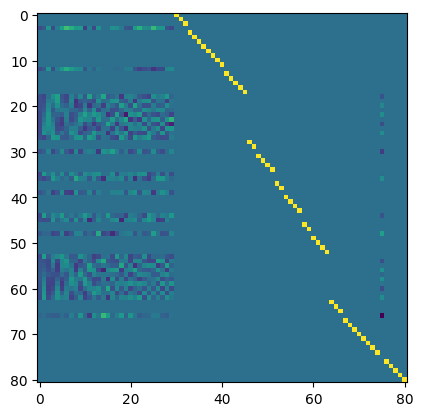

In [70]:
plt.imshow(eigvecs)

In [71]:
print(eigvals)

[9.99476904 8.03147296 6.73273777 5.4635957  4.53766063 3.41225399
 3.13803238 2.51086475 2.30503909 1.88842708 1.75248647 1.3639534
 1.29797636 1.18192104 1.00718674 1.00546662 0.87750209 0.81906631
 0.79554225 0.70222329 0.68062545 0.64248885 0.62465288 0.52666104
 0.53248207 0.59433924 0.54232979 0.54980706 0.56554555 0.58703846
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


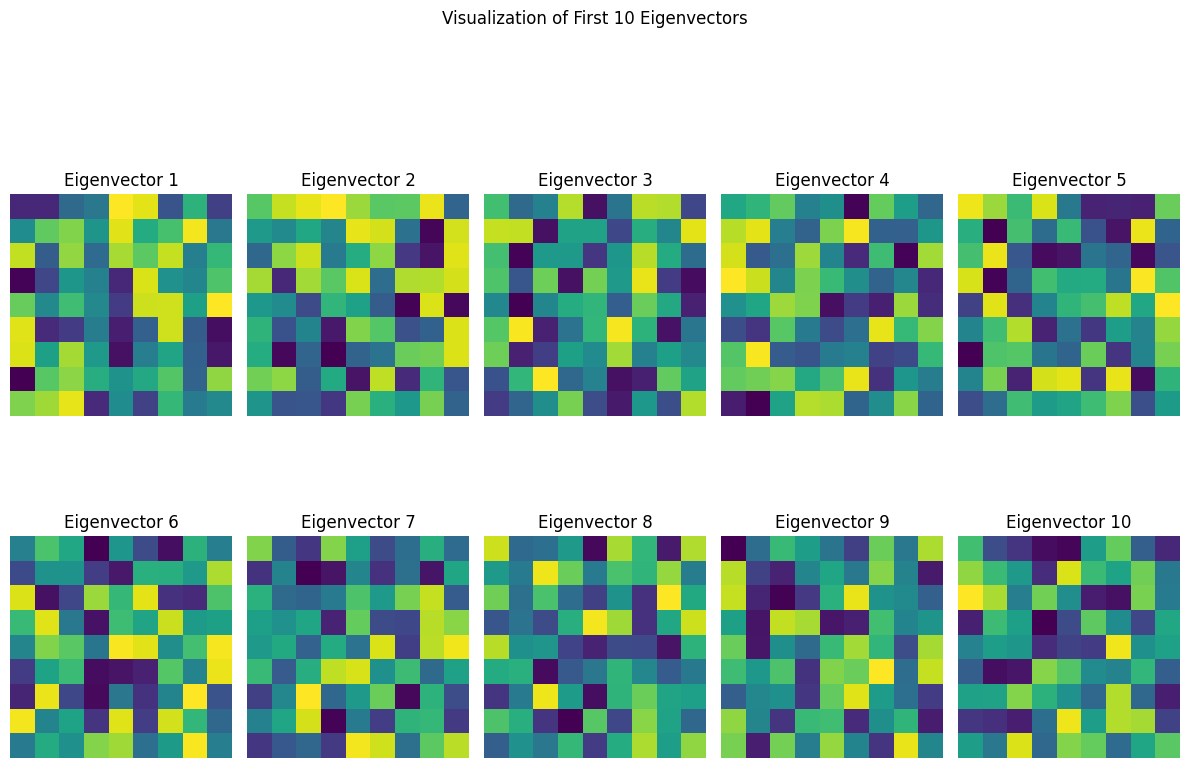

In [72]:
# Assuming eigvals and eigvecs are your eigenvalues and eigenvectors
# Replace these with your actual data
eigvals = np.random.rand(81)
eigvecs = np.random.rand(81, 81)

# Select the first 10 eigenvalues and eigenvectors
num_eigenpairs = 10
selected_eigvals = eigvals[:num_eigenpairs]
selected_eigvecs = eigvecs[:, :num_eigenpairs]

# Create a 3x4 subplot grid (adjust the layout accordingly)
fig, axs = plt.subplots(2, 5, figsize=(12, 9))
fig.suptitle('Visualization of First 10 Eigenvectors')

# Loop through the selected eigenvectors
for i in range(num_eigenpairs):
    row, col = divmod(i, 5)
    
    # Reshape eigenvector to 9x9
    eigvec_reshaped = selected_eigvecs[:, i].reshape((9, 9))
    
    # Plot eigenvector
    axs[row, col].imshow(eigvec_reshaped, cmap='viridis_r')
    axs[row, col].set_title(f'Eigenvector {i + 1}')
    axs[row, col].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
